# Fitting to biocontrol data
Uses data from: *Bacillus megaterium shows potential for the biocontrol of septoria tritici blotch of wheat, Kildea et al., 2008*

Note that there is some unresolved dependency in this file which means that in order for it to run correctly, it needs to be run in a clean workspace (i.e. only rerun after restarting the kernel)

In [1]:
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# For simulation
from Functions_base import ic_twofield, t_growing

# For ODEs
from Functions_base import beta_base, Temerge, gamma, g_1D, sigma, mu, v, T63

# For plotting
from Functions_base import G, Temerge, T61, T87, T39, T31
from Functions_plotting import c1,c2,c3,c4,c5, plot_one_intervention

In [2]:
# Disease system
def dPop(ic,t,epi_severity,eps):
    
    beta = beta_base*epi_severity
    
    S_M,E_M,I_M,R_M,D_M,P_M = ic[:6]
    S_N,E_N,I_N,R_N,D_N,P_N = ic[6:]
    
    A_M = S_M + E_M + I_M + R_M + D_M
    A_N = S_N + E_N + I_N + R_N + D_N
    
    # Biocontrol fields
    if t > Temerge:
        FOL = (1 - eps(t))*gamma*E_M
            
        # Set fungicide dependant transmission rate
        FOI = beta*(I_M + P_M)*(1 - eps(t))

        dS_M = g_1D(A_M,t) - sigma(t)*S_M - (S_M/A_M)*FOI
        dE_M = (S_M/A_M)*FOI - sigma(t)*E_M - FOL
        dI_M = FOL - mu*I_M
        dR_M = sigma(t)*(S_M+E_M)
        dD_M = mu*I_M
        dP_M = -v*P_M
        
    else:
        dS_M = 0
        dE_M = 0
        dI_M = 0
        dR_M = 0
        dD_M = 0
        dP_M = 0

    # Uncontrolled fields
    if t > Temerge:
        
        # Set uncontrolled FOI
        FOI = beta*(I_N + P_N)
        
        dS_N = g_1D(A_N,t) - sigma(t)*S_N - (S_N/A_N)*FOI
        dE_N = (S_N/A_N)*FOI - sigma(t)*E_N - gamma*E_N
        dI_N = gamma*E_N - mu*I_N
        dR_N = sigma(t)*(S_N+E_N)
        dD_N = mu*I_N
        dP_N = -v*P_N
        
    else:
        dS_N = 0
        dE_N = 0
        dI_N = 0
        dR_N = 0
        dD_N = 0
        dP_N = 0

    return [dS_M,dE_M,dI_M,dR_M,dD_M,dP_M, dS_N,dE_N,dI_N,dR_N,dD_N,dP_N]

In [3]:
# Kildea et al. paper data
# There's only one which is significantly different to the untreated trial, so I  use that one

# Times at which assessment is done, calendar days post GS61: 28, 32, 36, 40
# Over two years, 2004 and 2006
# GS61 is June 11th. Note that this is the calendar day INDEX so that 20th September is calendar day 0
day_GS61 = 264
assessment_calendar_days = [day_GS61+28, day_GS61+32, day_GS61+36, day_GS61+40]
print(assessment_calendar_days)

# Find the degree-day times of these dates using Hobbelen et al. data
# Read in Hobbelen time data, converts calendar days to degree days
T = pd.read_excel("Hobbelen_data/T - winter wheat_mine.xlsx", header=None,usecols=[0,1,2,3])
assessment_dds = np.array([T[3][assessment_calendar_days]])

[292, 296, 300, 304]


In [4]:
# Uncontrolled data (picked from the figure)
data_2004 = pd.read_csv("biocontrol_2004_data.csv")
nc_lower_2004 = np.array(data_2004[" y"][:4])
nc_upper_2004 = np.array(data_2004[" y"][5:9])
con_lower_2004 = np.array(data_2004[" y"][10:14])
con_upper_2004 = np.array(data_2004[" y"][15:19])

data_2006 = pd.read_csv("biocontrol_2006_data.csv")
nc_lower_2006 = np.array(data_2006[" y"][:4])
nc_upper_2006 = np.array(data_2006[" y"][5:9])
con_lower_2006 = np.array(data_2006[" y"][10:14])
con_upper_2006 = np.array(data_2006[" y"][15:19])

## Fitting to no control data
Fit for the outbreak severity and initial condition

In [5]:
# "Zero" version of the biocontrol function
def zeroeps(t):
    return 0

# Run without disease up to the start of the trial period
t_nodis = np.arange(0,T61,1)
ic = 1*ic_twofield
ic[5] = 0
ic[-1] = 0
pop1 = odeint(func = dPop, y0 = ic, t = t_nodis,args = (1, zeroeps))
pop_ipm1 = pop1[:,:5]
pop_nocontrol1 = pop1[:,6:-1]

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.668056210730821
             x: [ 3.825e+01  9.421e-09]
           nit: 307
          nfev: 565
 final_simplex: (array([[ 3.825e+01,  9.421e-09],
                       [ 3.825e+01,  9.421e-09],
                       [ 3.825e+01,  9.421e-09]]), array([ 4.668e+00,  4.668e+00,  4.668e+00]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 27.124587092065543
             x: [ 1.376e+02  4.599e-10]
           nit: 475
          nfev: 879
 final_simplex: (array([[ 1.376e+02,  4.599e-10],
                       [ 1.376e+02,  4.599e-10],
                       [ 1.376e+02,  4.599e-10]]), array([ 2.712e+01,  2.712e+01,  2.712e+01]))


27.124587092065543

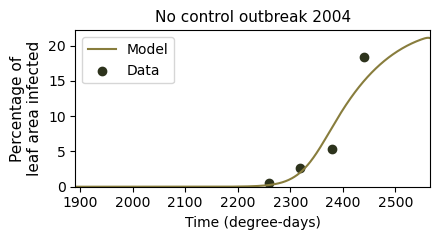

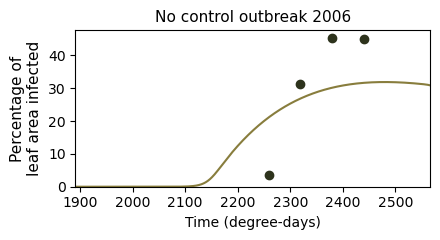

In [6]:
# Introduce disease by varied initial infection and severity
t_postdis = np.arange(T61,T87)

# First fit using the no-control data for the initial inoculum and the severity
def fit_for_conditions(paras,year,plot):
    
    # Effect of biocontrol set to 0
    omega = 0
    theta = 1
    delta = 1
    def eps(t):
        # Biocontrol concentration
        if t < T63:
            C = 0
        else:
            C = math.exp(-delta*(t-T63))

        return omega*(1-math.exp(-theta*C))
    
    # If invalid parameters are input, return infinity
    severity,initial_inf = paras
    if omega > 1 or initial_inf < 0 or severity < 0:
        return np.inf
    
    # Introduce disease at the start of trial period
    ic = 1*pop1[-1]
    ic[1] = initial_inf*ic[0]
    ic[0] = (1-initial_inf)*ic[0]
    ic[7] = initial_inf*ic[6]
    ic[6] = (1-initial_inf)*ic[6]

    # Run simulation
    pop2 = odeint(func = dPop, y0 = ic, t = t_postdis,args = (severity, eps))
    
    # Get no control data (although in this simulation both are without control)
    pop_nocontrol2 = pop2[:,6:-1]
    tot_nocontrol = np.sum(pop_nocontrol2, axis = 1)
    I_nocontrol = pop_nocontrol2[:,2]
    
    # Test at survey dates
    t_assess = assessment_dds - T61
    nc_percent = 100*I_nocontrol/tot_nocontrol
    
    # Get this year's data
    if year == "2004":
        nc_data = nc_lower_2004
    elif year == "2006":
        nc_data = nc_lower_2006
    
    # Compute error between model and data
    #diff = np.linalg.norm((nc_percent[t_assess] - nc_data)/nc_data)
    diff = np.linalg.norm(nc_percent[t_assess] - nc_data)
    
    # Plot if necessary
    if plot == True:
        fig,ax = plt.subplots(1,figsize=(4.5,2.5))
        ax.plot(t_postdis,nc_percent,label = "Model",c=c3)
        ax.scatter(t_assess + T61,nc_data,label = "Data",c=c5)
        
        if year == "2004":
            ax.legend(loc = "upper left")
        ax.set_ylabel("Percentage of\nleaf area infected",fontsize='11')
        ax.set_title("No control outbreak "+year,fontsize='11')
        ax.set_ylim(bottom=0)
        ax.set_xlim([t_postdis[0],t_postdis[-1]])
        ax.set_xlabel("Time (degree-days)")
        fig.tight_layout()
        
        fig.savefig('Figures/Manuscript_final/fig_biocontrolfitting'+year+'1.pdf', dpi=400)
        
    return diff

# 2004
x = minimize(fit_for_conditions,[1,0.01],args = ("2004",False),method="Nelder-Mead",options={'maxiter':1000})
print(x)
initial_conds_2004 = x["x"]
fit_for_conditions(initial_conds_2004,"2004",True)

# 2006
x = minimize(fit_for_conditions,[1,0.01],args = ("2006",False),method="Nelder-Mead",options={'maxiter':1000})
print(x)
initial_conds_2006 = x["x"]
fit_for_conditions(initial_conds_2006,"2006",True)

## Fitting to biocontrol data

[[0.17706948 4.17174347 2.33045199 1.98436948]]
[[0.13638952 4.00530382 2.26148591 1.9568917 ]]
[[0.16414117 4.11893579 2.30873005 1.97574959]]
[[0.21299569 4.31806207 2.38988374 2.00779602]]
[[0.10224585 3.86497793 2.20217248 1.93299558]]
[[0.04253828 3.61819699 2.0951489  1.88922111]]
[[0.05316181 3.66223578 2.11450841 1.89720454]]
[[-0.00995693  3.39975096  1.99737702  1.84843909]]
[[-0.10096171  3.01773473  1.81902089  1.77188852]]
[[-0.15473639  2.78999491  1.70789162  1.72262882]]
[[-0.32355186  2.06514965  1.32717912  1.54287883]]
[[-0.3183174   2.08785405  1.33978504  1.5491429 ]]
[[-0.55469266  1.04755147  0.70827034  1.19928023]]
[[-0.84207307 -0.26023768 -0.28954987  0.35531666]]
[[-0.90517637 -0.55408679 -0.55634103 -0.01163863]]
[[-0.9767576  -0.89068717 -0.88664472 -0.67586949]]
[[-0.99999524 -0.99999684 -0.99999951 -0.99999975]]
[[-0.99963684 -0.99870584 -0.99882576 -0.99652327]]
[[-0.64808863  0.62783534  0.41703538  1.00386785]]
[[-0.53547366  1.13330167  0.76492139  1

[[-0.00051866  0.08633834  0.05408895 -0.20601204]]
[[ 0.03803224  0.0966436   0.05900659 -0.20368176]]
[[-0.03612184  0.07653232  0.04939871 -0.20823611]]
[[ 0.04311263  0.09810909  0.05972458 -0.20333902]]
[[-0.02997846  0.07820801  0.05019538 -0.20785903]]
[[-0.0636497   0.06879125  0.04569556 -0.20999225]]
[[-0.00127469  0.08611761  0.05398124 -0.20606341]]
[[ 0.01520273  0.0905695   0.05610811 -0.20505521]]
[[-0.02340327  0.08005302  0.05108151 -0.20743831]]
[[-0.03591211  0.0765535   0.04940322 -0.20823474]]
[[-0.00938549  0.08390773  0.05292508 -0.20656411]]
[[-0.04045087  0.07530685  0.0488099  -0.20851569]]
[[-0.01111824  0.08342643  0.05269393 -0.20667386]]
[[ 0.00071493  0.08668402  0.05425583 -0.20593271]]
[[-0.02231417  0.08034023  0.05121691 -0.20737438]]
[[-0.02849481  0.07863082  0.0503993  -0.20776206]]
[[-0.01417098  0.08259227  0.05229554 -0.20686271]]
[[-0.00830617  0.08418755  0.05305666 -0.20650204]]
[[-0.01964081  0.08108709  0.0515756  -0.20720409]]
[[-0.0076363

0.22922327079773283

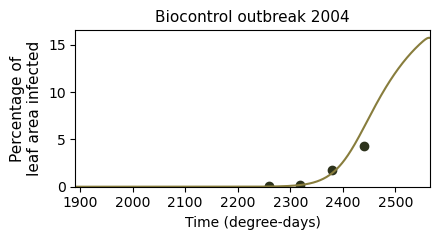

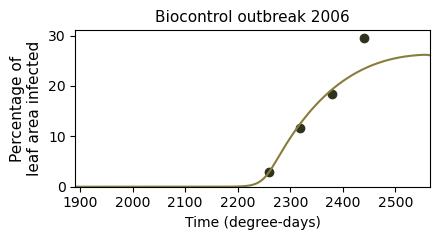

In [7]:
# First fit using the no-control data for the initial inoculum and the severity
def fit_for_biocontrol(paras,year,plot):
    
    # Get the previously fitted for outbreak data
    if year == "2004":
        severity, initial_inf = initial_conds_2004
    elif year == "2006":
        severity, initial_inf = initial_conds_2006
        
    # Effect of biocontrol
    def eps(t):
        # Biocontrol concentration
        if t < T63:
            C = 0
        else:
            C = math.exp(-delta*(t-T63))

        return omega*(1-math.exp(-theta*C))
    
    # If invalid parameters are input, return infinity
    omega,theta,delta = paras
    if omega > 1:
        return np.inf
    
    # Introduce disease at the start of trial period
    ic = 1*pop1[-1]
    ic[1] = initial_inf*ic[0]
    ic[0] = (1-initial_inf)*ic[0]
    ic[7] = initial_inf*ic[6]
    ic[6] = (1-initial_inf)*ic[6]

    # Run simulation
    pop2 = odeint(func = dPop, y0 = ic, t = t_postdis,args = (severity, eps))
    
    # Get IPM data
    pop_ipm2 = pop2[:,:5]
    tot_ipm = np.sum(pop_ipm2, axis = 1)
    I_ipm = pop_ipm2[:,2]
    
    # Test at survey dates
    t_assess = assessment_dds - T61
    ipm_percent = 100*I_ipm/tot_ipm
    
    # Get this year's data
    if year == "2004":
        ipm_data = con_lower_2004
    elif year == "2006":
        ipm_data = con_lower_2006
    
    # Compute error between model and data
    print((ipm_percent[t_assess] - ipm_data)/ipm_data)
    diff = np.linalg.norm((ipm_percent[t_assess] - ipm_data)/ipm_data)
    
    # Plot if necessary
    if plot == True:
        fig,ax = plt.subplots(1,figsize=(4.5,2.5))
        ax.plot(t_postdis,ipm_percent,label = "Model",c=c3)
        ax.scatter(t_assess + T61,ipm_data,label = "Data",c=c5)
        #ax.legend(loc = "upper left")
        ax.set_ylabel("Percentage of\nleaf area infected",fontsize='11')
        ax.set_title("Biocontrol outbreak "+year,fontsize='11')
        ax.set_ylim(bottom=0)
        ax.set_xlim([t_postdis[0],t_postdis[-1]])
        ax.set_xlabel("Time (degree-days)")
        fig.tight_layout()
        
        fig.savefig('Figures/Manuscript_final/fig_biocontrolfitting'+year+'2.pdf', dpi=400)
        
    return diff

# 2004
x = minimize(fit_for_biocontrol,[0.5,9,0.1],args = ("2004",False),method="Nelder-Mead",options={'maxiter':1000})
print(x)
paras_2004 = x["x"]
fit_for_biocontrol(paras_2004,"2004",True)

# 2006
x = minimize(fit_for_biocontrol,[0.5,9,0.1],args = ("2006",False),method="Nelder-Mead",options={'maxiter':1000})
print(x)
paras_2006 = x["x"]
fit_for_biocontrol(paras_2006,"2006",True)

## Run for paper figures using the best fitting of the two years (2004 or 2006)
We assume sprays are applied at T31 and T39 as this is when fungicide is usually sprayed.

In [8]:
# Input the best parameters (2004 or 2006)
omega, theta, delta =   6.999e-01,  1.027e+01,  3.809e-02
# Save them to be used in later simulations
np.save("biocontrol_fit_results.npy",[omega,theta,delta])

In [9]:
# Effect of biocontrol
def eps(biocontrol_dates):
    def biocontrol_sub(t):

        # Check that biocontrol dates are valid
        for i in biocontrol_dates:
            if i not in [31,39]:
                raise Exception("Can only have 31 or 39 as biocontrol dates")

        # Switch biocontrol on for the relevant dates
        if 31 in biocontrol_dates:
            d31 = 1
        else:
            d31 = 0

        if 39 in biocontrol_dates:
            d39 = 1
        else:
            d39 = 0

        # Fungicide concentration
        if t < T31:
            C = 0
        elif t < T39:
            C = d31*math.exp(-delta*(t-T31))
        else:
            C = d31*math.exp(-delta*(t-T31)) + d39*math.exp(-delta*(t-T39))

        return omega*(1-math.exp(-theta*C))
    return biocontrol_sub

Yields
[0.9246707944616883, 0.9427059344690464, 0.9579799686366183]
Peak percent infection
[0.11178389725962211, 0.0891761259719471, 0.06786637734366317]


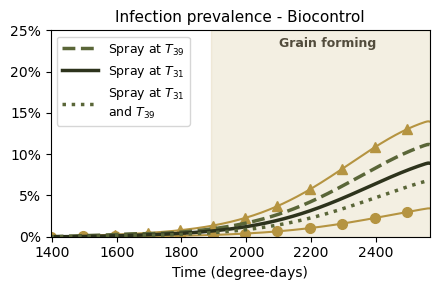

In [10]:
# Run simulations with different applications
pop1 = odeint(func = dPop, y0 = ic_twofield, t = t_growing,args = (1, eps([31])))
pop2 = odeint(func = dPop, y0 = ic_twofield, t = t_growing,args = (1, eps([39])))
pop3 = odeint(func = dPop, y0 = ic_twofield, t = t_growing,args = (1, eps([31,39])))
labels = ["Spray at $T_{31}$", "Spray at $T_{39}$", "Spray at $T_{31}$\nand $T_{39}$"]

# Run imported plotting function
fig,ax = plot_one_intervention([pop2[:,:6],pop1[:,:6],pop3[:,:6]],[labels[1],labels[0],labels[2]],"Biocontrol",fill=False)
plt.tight_layout()
# Save figure
fig.savefig('Figures/Manuscript_final/fig_1control_biocontrol.pdf', dpi=400)